In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import eden
import matplotlib.pyplot as plt
from eden.util import configure_logging
import logging

/home/ikea/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/ikea/miniconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/ikea/miniconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarni

In [ ]:
from itertools import tee, chain, islice
import numpy as np
import random
from time import time
import datetime
from graphlearn.graphlearn import Sampler as GraphLearnSampler
from eden.util import fit,estimate
from eden.path import Vectorizer
import random
# get data
from eden.converter.graph.gspan import gspan_to_eden
from itertools import islice
import random
'''
GET RNA DATA
'''
from eden.converter.fasta import fasta_to_sequence
import itertools

def rfam_uri(family_id):
    return 'http://rfam.xfam.org/family/%s/alignment?acc=%s&format=fastau&download=0'%(family_id,family_id)
def rfam_uri(family_id):
    return '%s.fa'%(family_id)
 

from eden.converter.fasta import fasta_to_sequence
def get_sequences_with_names(filename='RF00005.fa'):
    sequences = fasta_to_sequence("../toolsdata/"+filename)
    return sequences


def get_graphs(fname,size):
    graphs=[g for g in get_sequences_with_names(fname)]
    random.shuffle(graphs)
    return graphs[:size]

# formerly:
#get_graphs(dataset_fname, size=100)

In [ ]:
import random
import graphlearn.abstract_graphs.RNA as rna
from  graphlearn.feasibility import FeasibilityChecker as Checker
from graphlearn.estimator import Wrapper as estimatorwrapper
import graphlearn.utils.draw as draw
from graphlearn.graphlearn import Sampler as GLS
import itertools



def fit_sample(graphs, random_state=random.random()):
    '''
    graphs -> more graphs
    '''
    graphs = list(graphs)
    estimator=estimatorwrapper( nu=.5, cv=2, n_jobs=-1)
    sampler=rna.AbstractSampler(radius_list=[0,1],
                                thickness_list=[2], 
                                min_cip_count=1, 
                                min_interface_count=2, 
                                preprocessor=rna.PreProcessor(base_thickness_list=[1],ignore_inserts=True), 
                                postprocessor=rna.PostProcessor(),
                                estimator=estimator
                                #feasibility_checker=feasibility
                               )
    sampler.fit(graphs,grammar_n_jobs=4,grammar_batch_size=1)
    
    
    logger.info('graph grammar stats:')
    dataset_size, interface_counts, core_counts, cip_counts = sampler.grammar().size()
    logger.info('#instances:%d   #interfaces: %d   #cores: %d   #core-interface-pairs: %d' % (dataset_size, interface_counts, core_counts, cip_counts))
    
    
    graphs = [ b for a ,b in graphs  ]
    
    graphs = sampler.sample(graphs,
                            n_samples=3,
                            batch_size=1,
                            n_steps=50,
                            n_jobs=4,
                            quick_skip_orig_cip=True,
                            probabilistic_core_choice=True,
                            burnin=10,
                            improving_threshold=0.9,
                            improving_linear_start=0.3,
                            max_size_diff=20,
                            accept_min_similarity=0.65,
                            select_cip_max_tries=30,
                            keep_duplicates=False,
                            include_seed=False,
                            backtrack=10,
                            monitor=False)
    result=[]
    for graphlist in graphs:
        result+=graphlist
    # note that this is a list [('',sequ),..]
    return result

In [ ]:
def fit_and_evaluate(pos_original, neg_original,
                     pos_sampled, neg_sampled,
                     pos_test, neg_test,
                     random_state=42):
    '''
    pos + neg orig+sampled testsets -> orig_roc , sampled_roc, augmented_roc
    '''
    
    # create graph sets...orig augmented and sampled
    pos_orig,pos_orig_ = tee(pos_original)
    neg_orig,neg_orig_ = tee(neg_original)
    
    pos_sampled, pos_sampled_ = tee(pos_sampled)
    neg_sampled, neg_sampled_ = tee(neg_sampled)
    
    pos_augmented = chain(pos_orig_,pos_sampled_)
    neg_augmented = chain(neg_orig_,neg_sampled_)

    predictive_performances = []
    for desc,pos_train,neg_train in [('original',pos_orig, neg_orig),
                                     ('sample',pos_sampled,neg_sampled),
                                     ('original+sample',pos_augmented, neg_augmented)]:
        pos_train,pos_train_ = tee(pos_train)
        neg_train,neg_train_ = tee(neg_train)
        pos_size=sum(1 for x in pos_train_)
        neg_size=sum(1 for x in neg_train_)

        logger.info( "-"*80)
        logger.info('working on %s'%(desc))
        logger.info('training set sizes: #pos: %d #neg: %d'%(pos_size, neg_size))

        if pos_size == 0 or neg_size == 0:
            logger.info('WARNING: empty dataset')
            predictive_performances.append(0)            
        else:
            start=time()
            pos_test,pos_test_ = tee(pos_test)
            neg_test,neg_test_ = tee(neg_test)
            
            local_estimator = fit(pos_train, neg_train, Vectorizer(4), n_jobs=-1, n_iter_search=1)
            apr, roc = estimate(pos_test_, neg_test_, local_estimator, Vectorizer(4))
            predictive_performances.append(roc)
            logger.info( 'elapsed: %.1f sec'%(time()-start))
    return predictive_performances

In [ ]:
def evaluate(pos_fname, neg_fname, size=None, percentages=None, n_repetitions=None, train_test_split=None):
    # initializing 
    graphs_pos = get_graphs(pos_fname, size=size)
    graphs_neg = get_graphs(neg_fname, size=size)

    # train/test split
    from eden.util import random_bipartition_iter
    pos_train_global,pos_test_global = random_bipartition_iter(graphs_pos,train_test_split,random_state=random.random()*1000)
    neg_train_global,neg_test_global = random_bipartition_iter(graphs_neg,train_test_split,random_state=random.random()*1000)


    original_repetitions = []
    original_sample_repetitions = []
    sample_repetitions = []

    for percentage in percentages:
        originals = []
        originals_samples = []
        samples = []
        for repetition in range(n_repetitions):
            random_state = int(313379*percentage+repetition) 
            random.seed(random_state)
            pos_train_global,pos_train_global_ = tee(pos_train_global)
            neg_train_global,neg_train_global_ = tee(neg_train_global)
            pos_test_global,pos_test_global_ = tee(pos_test_global)
            neg_test_global,neg_test_global_ = tee(neg_test_global)

            # use shuffled list to create test and sample set
            pos,pos_reminder = random_bipartition_iter(pos_train_global_,percentage)
            pos,pos_ = tee(pos)
            neg,neg_reminder = random_bipartition_iter(neg_train_global_,percentage)
            neg,neg_ = tee(neg)

            #sample independently from the 2 classes
            logger.info('Positive')
            sampled_pos = fit_sample(pos_, random_state=random_state)
            logger.info('Negative')
            sampled_neg = fit_sample(neg_, random_state=random_state)

            #evaluate the predictive performance on held out test set
            start=time()
            logger.info( "="*80)
            logger.info( 'repetition: %d/%d'%(repetition+1, n_repetitions))
            logger.info( "training percentage:"+str(percentage))
            perf_orig,\
            perf_samp,\
            perf_orig_samp = fit_and_evaluate(pos,neg,
                                              sampled_pos,sampled_neg,
                                              pos_test_global_,neg_test_global_)
            logger.info( 'Time elapsed for full repetition: %.1f sec'%((time()-start)))
            originals.append(perf_orig)
            originals_samples.append(perf_orig_samp)
            samples.append(perf_samp)

        original_repetitions.append(originals)
        original_sample_repetitions.append(originals_samples)
        sample_repetitions.append(samples)
    
    return original_repetitions, original_sample_repetitions, sample_repetitions

In [ ]:
def plot(dataset, percentages, original_sample_repetitions, original_repetitions, sample_repetitions):
    gc={'color':'g'}
    rc={'color':'r'}
    bc={'color':'b'}
    FONTSIZE=20
    ws = 1
    os = np.mean(original_sample_repetitions, axis=1)
    o = np.mean(original_repetitions, axis=1)
    s = np.mean(sample_repetitions, axis=1)
    plt.figure(figsize=(18,8))
    ax = plt.subplot() 
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(20)
    
    
    plt.grid()
    plt.boxplot(original_sample_repetitions, positions=percentages, widths=ws, capprops=gc, medianprops=gc, boxprops=gc, whiskerprops=gc, flierprops=gc)
    plt.plot(percentages,os, color='g', marker='o', markeredgewidth=1, markersize=7, markeredgecolor='g', markerfacecolor='w', label='original+sample')

    plt.boxplot(original_repetitions, positions=percentages, widths=ws, capprops=rc, medianprops=rc, boxprops=rc, whiskerprops=rc, flierprops=rc)
    plt.plot(percentages,o, color='r', marker='o', markeredgewidth=1, markersize=7, markeredgecolor='r', markerfacecolor='w', label='original')

    plt.boxplot(sample_repetitions, positions=percentages, widths=ws, capprops=bc, medianprops=bc, boxprops=bc, whiskerprops=bc, flierprops=bc)
    plt.plot(percentages,s, color='b', marker='o', markeredgewidth=1, markersize=7, markeredgecolor='b', markerfacecolor='w', label='sample')

    plt.xlim(percentages[0]-.05,percentages[-1]+.05)
    plt.xlim(2,15)
    #plt.ylim(0.99,1.005)
    plt.ylim(0.0,1.005)
    plt.title(dataset+'\n',fontsize=20)
    plt.legend(loc='lower right',fontsize=18)
    plt.ylabel('ROC AUC',fontsize=18)
    plt.xlabel('Training set size per family',fontsize=18)
    plt.savefig('%s_plot_predictive_performance_of_samples.pdf' % dataset)

#load("DATAS")
#plot("RF00162 vs RF00005 learning curve", percentages_l, original_sample_repetitions_l, original_repetitions_l, sample_repetitions_l)

In [ ]:
'''
def save_results(result_fname,percentages, original_repetitions,original_sample_repetitions,sample_repetitions):
    with open(result_fname,'w') as f:
        f.write('dataset sizes list:\n')
        for perc in percentages:
            f.write('%s '% perc)
        f.write('\n')
        f.write('AUC scores:\n')
        for repetitions in original_repetitions,original_sample_repetitions,sample_repetitions:
            f.write('%s\n' % len(repetitions))
            for repetition in repetitions:
                for auc in repetition:
                    f.write('%s ' % auc)
                f.write('\n')
    
def load_results(result_fname):
    with open(result_fname) as f:
        comment = next(f)
        line = next(f)
        percentages = [float(x) for x in line.split()]
        comment = next(f)

        original_repetitions = []
        size = int(next(f))
        for i in range(size):
            line = next(f)
            repetition = [float(x) for x in line.split()]
            original_repetitions.append(repetition)

        original_sample_repetitions = []
        size = int(next(f))
        for i in range(size):
            line = next(f)
            repetition = [float(x) for x in line.split()]
            original_sample_repetitions.append(repetition)


        sample_repetitions = []
        size = int(next(f))
        for i in range(size):
            line = next(f)
            repetition = [float(x) for x in line.split()]
            sample_repetitions.append(repetition)
            
    return percentages, original_repetitions,original_sample_repetitions,sample_repetitions
'''

#Experimental pipeline

In [ ]:
#plot("RF00162 vs RF01725", percentages_l, original_sample_repetitions_l, original_repetitions_l, sample_repetitions_l)

#print '%s_predictive_performance_of_samples.data'%dataset
#!cat "RF00162 vs RF00005 training curve_predictive_performance_of_samples.data"

In [ ]:
#percentages_l, original_repetitions_l,original_sample_repetitions_l,sample_repetitions_l = load_results('%s_predictive_performance_of_samples.data'%dataset)
#plot(dataset, percentages_l, original_sample_repetitions_l, original_repetitions_l, sample_repetitions_l)

In [ ]:
'''
%%time
#special case: bursi

dataset='RF00162 vs RF00005 training curve'
#logging
logger = logging.getLogger()
if True:
    logger_fname = '%s_predictive_performance_of_samples.log'%dataset
else:
    logger_fname = None
configure_logging(logger,verbosity=1, filename=logger_fname)

#main 
start=time()
print( 'Working with dataset: %s' % dataset )

logger.info( 'Working with dataset: %s' % dataset )
pos_dataset_fname = 'RF00005.fa'
neg_dataset_fname = 'mixed.fa'

pos_dataset_fname = 'RF00162.fa'
neg_dataset_fname = 'RF01725.fa'

percentages=[.08,.2,.4,.6,.8,.95]
percentages=[.07,0.1,0.15,0.2]
percentages=[.07,.1]


# set size to 900 in production
original_repetitions,\
original_sample_repetitions,\
sample_repetitions = evaluate(pos_dataset_fname,
                              neg_dataset_fname,
                              size=100,
                              percentages=percentages,
                              n_repetitions=6, # ORIG = 10
                              train_test_split=0.7)
#save and display results
result_fname='%s_predictive_performance_of_samples.data'%dataset
save_results(result_fname,percentages, original_repetitions,original_sample_repetitions,sample_repetitions) 


percentages_l, original_repetitions_l,original_sample_repetitions_l,sample_repetitions_l = load_results('%s_predictive_performance_of_samples.data'%dataset)
plot(dataset, percentages_l, original_sample_repetitions_l, original_repetitions_l, sample_repetitions_l)

print('Time elapsed: %s'%(datetime.timedelta(seconds=(time() - start))))
'''

In [ ]:
'''time
for dataset in dataset_names:
    #logging
    logger = logging.getLogger()
    if True:
        logger_fname = '%s_predictive_performance_of_samples.log'%dataset
    else:
        logger_fname = None
    configure_logging(logger,verbosity=1, filename=logger_fname)
    
    #main 
    start=time()
    print( 'Working with dataset: %s' % dataset )

    logger.info( 'Working with dataset: %s' % dataset )
    pos_dataset_fname = "RF00005.fa"
    neg_dataset_fname = 'mixed.fa

    percentages=[.05,.2,.4,.6,.8,.95]
    percentages=[.05,.2]

    original_repetitions,\
    original_sample_repetitions,\
    sample_repetitions = evaluate(pos_dataset_fname,
                                  neg_dataset_fname,
                                  size=400,
                                  percentages=percentages,
                                  n_repetitions=3,
                                  train_test_split=0.7)
    #save and display results
    result_fname='%s_predictive_performance_of_samples.data'%dataset
    save_results(result_fname,percentages, original_repetitions,original_sample_repetitions,sample_repetitions)    
    percentages_l, original_repetitions_l,original_sample_repetitions_l,sample_repetitions_l = load_results(result_fname)
    plot(dataset, percentages_l, original_sample_repetitions_l, original_repetitions_l, sample_repetitions_l)
    
    print('Time elapsed: %s'%(datetime.timedelta(seconds=(time() - start))))
'''

In [ ]:
#display
'''
for dataset in dataset_names:
    result_fname='%s_predictive_performance_of_samples.data'%dataset
    percentages_l, original_repetitions_l,original_sample_repetitions_l,sample_repetitions_l = load_results(result_fname)
    plot(dataset, percentages_l, original_sample_repetitions_l, original_repetitions_l, sample_repetitions_l)
''' 

.

In [ ]:
from eden.converter.fasta import fasta_to_sequence
import matplotlib.pyplot as plt
# we always want a test and a train set to omou
def get_seq_tups(fname,size,sizeb):
    kram = fasta_to_sequence("../toolsdata/"+fname)
    graphs=[g for g in kram]
    random.shuffle(graphs)
    return graphs[:size],graphs[size:size+sizeb]

def plot(dataset, percentages, original_sample_repetitions, original_repetitions, sample_repetitions): # note that the var names are not real anymore.
    gc={'color':'g'}
    rc={'color':'r'}
    bc={'color':'b'}
    FONTSIZE=20
    ws = .3
    os = np.mean(original_sample_repetitions, axis=1)
    o = np.mean(original_repetitions, axis=1)
    s = np.mean(sample_repetitions, axis=1)
    plt.figure(figsize=(18,8))
    ax = plt.subplot() 
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(20)
    
    plt.grid()
    plt.boxplot(original_sample_repetitions, positions=percentages, widths=ws, capprops=gc, medianprops=gc, boxprops=gc, whiskerprops=gc, flierprops=gc)
    plt.plot(percentages,os, color='g', marker='o', markeredgewidth=1, markersize=7, markeredgecolor='g', markerfacecolor='w', label='original')

    plt.boxplot(original_repetitions, positions=percentages, widths=ws, capprops=rc, medianprops=rc, boxprops=rc, whiskerprops=rc, flierprops=rc)
    plt.plot(percentages,o, color='r', marker='o', markeredgewidth=1, markersize=7, markeredgecolor='r', markerfacecolor='w', label='sample')

    plt.boxplot(sample_repetitions, positions=percentages, widths=ws, capprops=bc, medianprops=bc, boxprops=bc, whiskerprops=bc, flierprops=bc)
    plt.plot(percentages,s, color='b', marker='o', markeredgewidth=1, markersize=7, markeredgecolor='b', markerfacecolor='w', label='sample+orig')

    # testing to plot some dots
    global similarity_scores
    plt.plot(percentages,similarity_scores,'bo')
    
    plt.xlim(percentages[0]-.05,percentages[-1]+.05)
    plt.xlim(5,20)
    plt.ylim(0.0,1.005)
    plt.title(dataset+'\n',fontsize=20)
    plt.legend(loc='lower right',fontsize=18)
    plt.ylabel('ROC AUC',fontsize=18)
    plt.xlabel('Training set size per family',fontsize=18)
    plt.savefig('%s_plot_predictive_performance_of_samples.pdf' % dataset)

#load("DATAS")
#plot("RF00162 vs RF00005 learning curve", [30,70], [[.30,.30],[.20,.20]] , [[.40,.40],[.30,.30]],[[.70,.35],[.25,.25]])
import random
import graphlearn.abstract_graphs.RNA as rna
from  graphlearn.feasibility import FeasibilityChecker as Checker
from graphlearn.estimator import Wrapper as estimatorwrapper
import graphlearn.utils.draw as draw
from graphlearn.graphlearn import Sampler as GLS
import itertools



def fit_sample(graphs, random_state=random.random()):
    '''
    graphs -> more graphs
    '''
    graphs = list(graphs)
    estimator=estimatorwrapper( nu=.5, cv=2, n_jobs=-1)
    sampler=rna.AbstractSampler(radius_list=[0,1],
                                thickness_list=[2], 
                                min_cip_count=1, 
                                min_interface_count=2, 
                                preprocessor=rna.PreProcessor(base_thickness_list=[1],ignore_inserts=True), 
                                postprocessor=rna.PostProcessor(),
                                estimator=estimator
                                #feasibility_checker=feasibility
                               )
    sampler.fit(graphs,grammar_n_jobs=4,grammar_batch_size=1)
    graphs = [ b for a ,b in graphs  ]
    graphs = sampler.sample(graphs,
                            n_samples=3,
                            batch_size=1,
                            n_steps=50,
                            n_jobs=4,
                            quick_skip_orig_cip=True,
                            probabilistic_core_choice=True,
                            burnin=10,
                            improving_threshold=0.3,
                            improving_linear_start=0.2,
                            max_size_diff=20,
                            accept_min_similarity=0.65,
                            select_cip_max_tries=30,
                            keep_duplicates=False,
                            include_seed=False,
                            backtrack=2,
                            monitor=False)
    result=[]
    for graphlist in graphs:
        result+=graphlist
    # note that this is a list [('',sequ),..]
    return result


In [ ]:
from copy import deepcopy
import numpy as np
#  ok erstmal ueber alle x values, ne
size_test=20
dataset_a='RF00005.fa'
dataset_a='RF01725.fa'
dataset_b='RF00162.fa'
sizes=[7,8,9,10,11,12,13,14,15]
sizes=[7,8]
repeats=1

# calc everything
def get_results():
    li = [ get_datapoint(size) for size in sizes ]
    # transpose , should work OO 
    print 'li:',li
    return [list(i) for i in zip(*li)]

from graphlearn import sumsim
# calc for one "size", go over repeats
def get_datapoint(size):
    ra=[]
    rb=[]
    rab=[]
    similarities=[]
    global similarity_scores
    
    for rep in range(repeats):
        train_a,test_a = get_seq_tups(dataset_a,size,size_test)
        train_b,test_b = get_seq_tups(dataset_b,size,size_test)
        a,b,ab,similarity = evaluate_point(train_a,train_b,test_a,test_b)
        ra.append(a)
        rab.append(ab)
        rb.append(b)
        similarities.append(similarity)

    similarity_scores.append( (sum(similarities)/float(len(similarities))))
    return ra,rb,rab


def evaluate_point(train_a,train_b,test_a,test_b):
    res=[]
    res.append(  test(deepcopy(train_a),deepcopy(train_b),deepcopy(test_a),deepcopy(test_b)) )
    train_aa = fit_sample(train_a)
    train_bb = fit_sample(train_b)
    
    eins=sumsim.calcsimset(deepcopy(train_aa),deepcopy(train_a))   
    zwei=sumsim.calcsimset(deepcopy(train_bb),deepcopy(train_b))   
    drei = (eins+zwei)/2.0
    res.append(  test(deepcopy(train_aa),deepcopy(train_bb),deepcopy(test_a),deepcopy(test_b)) )
    res.append(  test(deepcopy(train_a)+deepcopy(train_aa),deepcopy(train_b)+train_bb,deepcopy(test_a),deepcopy(test_b)) )
    res.append(drei)
    return res



### just evaluate the stuff
from sklearn.linear_model import SGDClassifier
from eden.path import Vectorizer

def train_esti(neg,pos):
        v=Vectorizer()
        matrix=v.transform(neg+pos)
        res=SGDClassifier(shuffle=True)
        res.fit(matrix, np.asarray(  [-1]*len(neg)+[1]*len(pos)  ) )
        return res

def eva(esti,ne,po):
    v=Vectorizer()
    matrix=v.transform(ne)
    correct= sum(  [1 for res in esti.predict(matrix) if res == -1] ) 
    matrix2=v.transform(po)            
    correct+= sum(  [1 for res in esti.predict(matrix2) if res == 1] )
    return correct

def test(a,b,ta,tb):
    est=train_esti(a,b)
    correct=eva(est,ta,tb)
    return correct/float(size_test*2) # fraction correct
    

global similarity_scores
similarity_scores=[]
r=get_results()

In [ ]:
plot('somename', sizes, *r)

print similarity_scores
print sizes
print r


In [ ]:
def levenshtein(s1, s2):
    if len(s1) < len(s2):
        return levenshtein(s2, s1)
    # len(s1) >= len(s2)
    if len(s2) == 0:
        return len(s1)
    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1 # j+1 instead of j since previous_row and current_row are one character longer
            deletions = current_row[j] + 1       # than s2
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    return previous_row[-1]


def sim(s1,s2):
    l = float( max(len(s1),len(s2))) 
    lp = l - float(levenshtein(s1,s2))
    return lp/l 


print 'testing sim eq', sim(s1[0],s1[0])
print 'testing sim dif', sim(s2[0],s1[0])

s1=['asdasd','asdasd','abc']
s2=['zxczxc','asdasd','abc']


def simsum(a,b,del_diag=False):
    res=0.0
    for i, ea in enumerate(a):
        for j, eb in enumerate(b):
            if del_diag and i==j:
                continue
            res+=simmilarity(ea,eb)
    return res


print 'testing simsum eq',simsum(s1,s1,True)
print 'testing simsum neq',simsum(s2,s1)

import math
def calcsimset(a,b):
    print 'calcsimset'
    ab=simsum(s1,s2,False)
    aa=simsum(a,a,False) 
    bb=simsum(b,b,False)
    print ab,aa,bb
    cc=aa*bb
    print cc
    print ab/math.sqrt(cc)

    
calcsimset(s1,s2)


In [ ]:
from graphlearn import sumsim
print sumsim.__file__
s1=['asdasd','asdasd','abc']
s2=['zxczxc','asdasd','abc']
sumsim.calcsimset(s1,s2)
sumsim.similarity_mean(s1,s2)

In [ ]:
%load_ext autoreload
s1 = [('', 'CUCUUAUUGAGAGCGGUGGAGGGACUGGCCCUGUGAAACCCGGCAACCUUCAAACGAAAUGUUUGAAACGGUGCUAAUACCUGCAAAACGAAUGUUUUGCAUAAUAAGAG'), ('', 'CUCUUAUCCUGAGUGGCGGAGGGACAGGCCCAAUGAAGCCCAGCAACCUCUUCUUAAUUGAAGAAAGGUGCCAAACCGUUUGCAGACAAAUAGCGUCUGAACGAUAAGAG'), ('', 'CUCUUAUCCUGAGUGGCGGAGGGAAAGGCCCAAUGAAGCCCAGCAACCUCUUCUUAAUUGAAGAAAGGUGCCAAACCGUUUGCAGACAAAUAGCGUCUGAACGAUAAGAG'), ('', 'CUCUUAUCCUGAGUGGCGGAGGGAAACGGCCCAAUGAAGCCCAGCAACCUCUUCUUAAUUGAAGAAAGGUGCCAAACCGUUUGCAGACAAAUAGCGUCUGAACGAUAAGAG'), ('', 'AGCUCAUCCAGAGGGGCAGAGGGAAACGGCCCGAUGAAGCCCCGGCAACCCUCCAGUCGGUACUCGUAGGUCACUGAUUAUGAUAGGGAAGGUGCCAAAUCCGUCUCACGGCGAGAUGCGUCGUGAGGAAGAUGAGGA'), ('', 'UGCUUAUCUAGAGUGGCGGAGGGAAACGGCCCUUUGAAGCCCAGCAACCUCUUCUUAAUUGAAGAAAGGUGCCAAUUCCAGACAGAUGAGGA'), ('', 'UUCUUAUCAAGAGUUGGCGGAGAUACAAGGAUCUGUGAUGCCACAGCAACCUAUAUUUAUUAUGUGGUGCUAAUUCCUUUUGGCAAAAUCUAAGCCUGAAAGAUGAGAA'), ('', 'CUUUUAUCCAGAGAUGGCGGAGGGACAGGCCCGAAGAAGCCCAGCAACCUCUUCUUAAUUGAAGAAAGGUGCCAACCUGCAGAAUGCUCGGCGUUCUGGAAGAUAAGAG'), ('', 'CUUUUAUCCAGAGAUGGCGGAGGGAAAGGCCCGAAGAAGCCCAGCAACCUCUUCGUAACGAAGAAAGGUGCCAACCUGCAGAAUGCUCGGCGUUCUGGAAGAUAAGAG'), ('', 'AGCUUAUCGAGAGUUGGCGGAGAUACAAGGAUCUGUGAUGCCACAGCAACCUAUAUUUAUUAUGUGGUGCUAAUUCCCAUCCCGAAUAUUCGGGAAUAGAUGAGCG')] 
s2 = [('ACEZ01000126.1/65345-65190', 'AGCUCAUCCAGAGGGGCAGAGGGAAACGGCCCGAUGAAGCCCCGGCAACCCUCCAGUCGGUACUCGUAGGUCACUGGCGACCACUUCGCGAGGCUCCCGACUAGGGAAGGUGCCAAAUCCGUCUCACGGCGAGAUGCGUCGUGAGGAAGAUGAGGA'), ('AP008934.1/1011112-1011223', 'CUCUUAUCCUGAGUGGCGGAGGGACAUGGACCCAAUGAAGCCCAGCAACCUCUUCUUAAUUGAAGAAAGGUGCCAAACCGUUUGCAGACAAAUAGCGUCUGAACGAUAAGAG'), ('AAVL02000036.1/100921-100817', 'CUCUUAUUAAGAGUUGGCGGAGAUACAAGGAUCUGUGAUGCCACGGCAACCCCCGAUUAUGAUGGAAGGUGCCCACCGGAGCAAUGCAAUAUUGAUCAAUAAGAG'), ('AE017225.1/4074580-4074471', 'CUCUUAUUGAGAGCGGUGGAGGGAAAGGCCCUGUGAAACCCGGCAACCUUCAAACGAAAUGUUUGAAACGGUGCUAAUACCUGCAAAACGAAUGUUUUGCAUAAUAAGAG'), ('ABDQ01000003.1/211832-211918', 'UGCUUAUCUAGAGUGGCGGAGGGACUGGCCCUUUGAAGCCCAGCAACCUAUAUUUAUUAUGUGGUGCUAAUUCCAGACAGAUGAGGA'), ('AP006627.1/3008449-3008342', 'CUUUUAUCCAGAGAUGGCGGAGGGACAGGCCCGAAGAAGCCCAGCAACCAACACGUAACGUGUAAAGGUGCUAACCUGCAGAAUGCUCGGCGUUCUGGAAGAUAAGAG'), ('AAXV01000005.1/126573-126679', 'UUCUUAUCAAGAGAGACGGAGGGAUCGGCCCGAUGAAGUCUCAGCAACCAGCUCAAUCAGUAUGGUGCUAAUUCCUUUUGGCAAAAUCUAAGCCUGAAAGAUGAGAA'), ('AAXU02000001.1/3185191-3185093', 'AGCUUAUCGAGAAAGACUGAGGGAAGGGCCCGACGACGUCUUAGCAACCUGUAACCAAGGUGCUAAUUCCCAUCCCGAAUAUUCGGGAAUAGAUGAGCG')]


from Valium import sumsim as ss
print ss.__file__
#sumsim.calcsimset(s1,s2)
#ss.score(s1,s2)
a,b = ss.vectorize(s1,s2)
dist= ss.compdistr(a,b)
print dist
sim = ss.simset(a,b)
print 'sim',sim
print dist-sim

In [ ]:
import numpy as np
a=np.ones(4)

In [ ]:
np.sum(a)

In [ ]:
def get_datapoint(size):
    ra=[]
    rb=[]
    rab=[]
    similarities=[]
    global similarity_scores
    for rep in range(repeats):


        a,b,ab,similarity = evaluate_point(size)
        ra.append(a)
        rab.append(ab)
        rb.append(b)
        similarities.append(similarity)
        
    similarity_scores.append( 
        (sum(similarities)/float(len(similarities)))
        )
    return ra,rb,rab

In [ ]:
def evaluate_point(size):
    res=[]

    train_aa,train_a,test_a = get_trainthings(size,dataset_a)
    train_bb,train_b,test_b = get_trainthings(size,dataset_b)


    res.append(  
        test(deepcopy(train_a),deepcopy(train_b),deepcopy(test_a),deepcopy(test_b)) 
    )
    eins=sumsim.simset(deepcopy(train_aa),deepcopy(train_a))
    zwei=sumsim.simset(deepcopy(train_bb),deepcopy(train_b)) 
    drei = (eins+zwei)/2.0
    res.append(  test(deepcopy(train_aa),deepcopy(train_bb),deepcopy(test_a),deepcopy(test_b)) )
    res.append(  test(deepcopy(train_a)+deepcopy(train_aa),deepcopy(train_b)+train_bb,deepcopy(test_a),deepcopy(test_b)) )
    res.append(drei)
    return res

In [ ]:
import curve

sizes = [20, 25]
result = [[[0.95], [1.0]], [[0.975], [0.9]], [[0.95], [1.0]]]

sizes = [20, 25]
result = [[[1.0, 0.95, 1.0], [1.0, 0.975, 1.0]], [[0.775, 0.775, 0.925], [1.0, 1.0, 0.925]], [[0.975, 0.95, 0.975], [0.875, 0.975, 1.0]]]
similarity_scores = [1.0297192402202902, 1.0271841248414073]
curve.similarity_scores = similarity_scores 

result = [
            [
                [1.0, 1.0, 0.975, 0.975, 0.95, 1.0, 1.0, 1.0, 1.0], 
                [1.0, 0.95, 1.0, 1.0, 1.0, 0.975, 0.975, 1.0, 0.975], 
                [0.975, 1.0, 1.0, 0.975, 0.95, 1.0, 1.0, 1.0, 1.0],
                [1.0, 1.0, 1.0, 0.975, 1.0, 1.0, 1.0, 1.0, 1.0], 
                [0.925, 0.95, 0.975, 1.0, 1.0, 0.975, 1.0, 1.0, 0.975], 
                [1.0, 0.975, 1.0, 1.0, 1.0, 1.0, 0.975, 1.0, 1.0], 
                [0.975, 1.0, 1.0, 1.0, 0.975, 1.0, 1.0, 1.0, 1.0]], 
            [
                [0.825, 1.0, 0.9, 1.0, 0.975, 0.825, 0.725, 0.6, 1.0], 
                [0.675, 0.9, 0.775, 1.0, 0.85, 1.0, 0.8, 0.85, 0.975], 
                [1.0, 1.0, 0.975, 0.975, 0.9, 0.975, 1.0, 1.0, 1.0], 
                [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.975, 1.0], 
                [1.0, 1.0, 1.0, 0.975, 0.95, 1.0, 1.0, 1.0, 1.0], 
                [0.975, 0.975, 1.0, 1.0, 0.975, 0.975, 0.975, 0.975, 1.0], 
                [1.0, 1.0, 0.975, 1.0, 1.0, 1.0, 1.0, 1.0, 0.975]], 
           [
                [0.975, 0.975, 1.0, 0.975, 0.975, 1.0, 1.0, 1.0, 1.0], 
                [1.0, 1.0, 1.0, 1.0, 1.0, 0.975, 0.95, 1.0, 1.0], 
                [1.0, 1.0, 0.95, 0.975, 0.975, 1.0, 0.95, 1.0, 1.0], 
                [1.0, 0.975, 1.0, 0.975, 1.0, 0.975, 1.0, 1.0, 1.0], 
                [0.975, 1.0, 1.0, 0.875, 1.0, 1.0, 1.0, 1.0, 1.0], 
                [1.0, 0.975, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 
                [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]
        ]
similarity_scores = [1.0232968855718843, 1.0007455908832672, 0.99180448653574027, 0.98595714838649307, 0.9916254516732721, 0.98422063083413702, 0.98257742970417483]

result = [[[1.0, 0.975, 0.975, 1.0, 0.975, 0.975, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 0.95, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 0.975, 1.0, 1.0, 1.0, 1.0], [0.95, 1.0, 0.975, 1.0, 0.975, 1.0, 0.975, 0.975, 1.0], [1.0, 0.925, 1.0, 1.0, 1.0, 1.0, 1.0, 0.975, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.975], [1.0, 1.0, 1.0, 0.975, 1.0, 1.0, 1.0, 1.0, 0.975]], [[0.975, 0.975, 1.0, 0.825, 0.925, 0.925, 0.95, 1.0, 0.975], [1.0, 1.0, 1.0, 0.875, 1.0, 1.0, 0.95, 1.0, 0.975], [1.0, 0.95, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.975], [1.0, 0.975, 0.95, 1.0, 1.0, 1.0, 0.975, 1.0, 1.0], [0.975, 0.95, 0.975, 1.0, 1.0, 0.975, 0.975, 0.975, 0.975], [1.0, 1.0, 1.0, 1.0, 0.975, 0.95, 1.0, 1.0, 0.925], [1.0, 1.0, 1.0, 0.975, 1.0, 0.975, 1.0, 1.0, 0.975]], [[1.0, 1.0, 0.975, 1.0, 1.0, 1.0, 0.85, 1.0, 1.0], [1.0, 1.0, 0.975, 0.975, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 0.975, 1.0, 1.0, 0.975, 1.0, 1.0, 0.95], [1.0, 1.0, 0.825, 1.0, 1.0, 1.0, 0.975, 0.975, 1.0], [0.975, 1.0, 0.975, 0.975, 0.875, 1.0, 0.975, 1.0, 0.975], [1.0, 1.0, 1.0, 0.975, 1.0, 0.95, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]]
similarity_scores = [1.0168101311663511, 1.0150377354846287, 1.0009668568440384, 1.0013156444262343, 0.99809664727147385, 0.99622003788844737, 0.99512742871661353]

numgr=[20 ,25 ,30, 35, 40, 45, 50]

result = [[[0.99, 0.985, 0.985, 0.99, 0.99, 0.985, 0.985], [0.955, 0.985, 1.0, 0.99, 0.97, 0.975, 0.975], [0.985, 0.975, 0.95, 0.965, 0.965, 0.985, 0.96], [0.975, 0.955, 0.975, 0.995, 0.98, 0.975, 0.995], [0.99, 0.99, 0.99, 0.985, 0.98, 0.99, 0.985], [0.98, 0.965, 0.975, 0.98, 0.97, 0.985, 0.99], [0.995, 0.975, 0.98, 0.99, 0.995, 0.985, 0.995]], [[0.995, 0.985, 0.835, 0.78, 0.91, 0.965, 0.975], [0.995, 0.93, 0.985, 0.99, 0.98, 0.985, 0.98], [0.965, 0.845, 0.98, 0.95, 0.925, 0.975, 0.985], [0.975, 0.985, 0.975, 0.97, 0.955, 0.985, 0.985], [0.995, 0.99, 0.995, 0.985, 0.99, 0.98, 0.99], [0.99, 1.0, 0.985, 0.99, 0.995, 0.98, 0.995], [0.99, 0.985, 0.945, 0.945, 0.985, 0.99, 0.985]], [[0.99, 0.995, 1.0, 0.995, 0.99, 0.995, 1.0], [1.0, 0.98, 0.975, 0.945, 0.99, 1.0, 0.98], [0.985, 0.985, 0.975, 0.995, 0.98, 0.975, 0.97], [0.995, 0.985, 0.985, 0.985, 0.98, 0.975, 0.975], [0.985, 0.995, 0.985, 0.995, 0.995, 0.995, 0.98], [0.985, 0.995, 0.995, 0.99, 0.98, 0.99, 0.995], [0.995, 0.99, 0.995, 0.99, 0.995, 0.98, 0.985]]]
similarity_scores = [1.009134975438486, 1.0020476673182956, 0.99512728715033838, 0.9902838600590177, 0.98878387701645598, 0.98004841660025499, 0.97223030477865113]

curve.similarity_scores=similarity_scores
curve.plot("%s vs %s discriminative performance" % (curve.dataset_a[:-3],curve.dataset_b[:-3]),numgr,*result)

In [ ]:
l=np.array(range(4))
l.tolist()*7

[ 25  50  75 100]
[ 25  50  75 100]
[ 25  50  75 100]
[ 25  50  75 100]


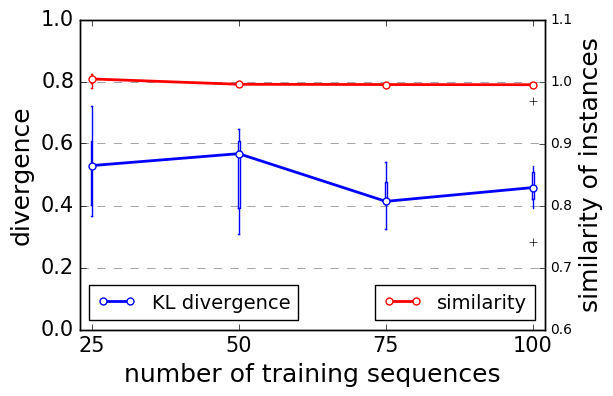

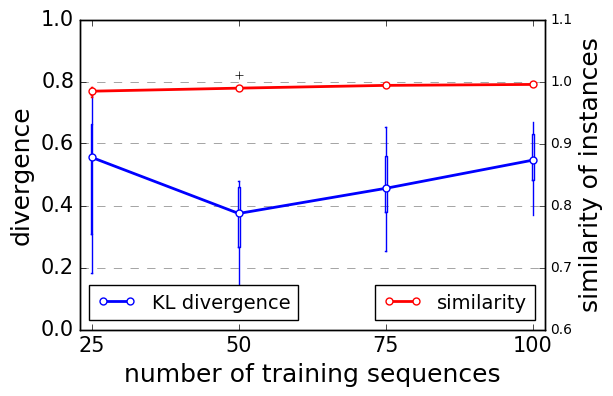

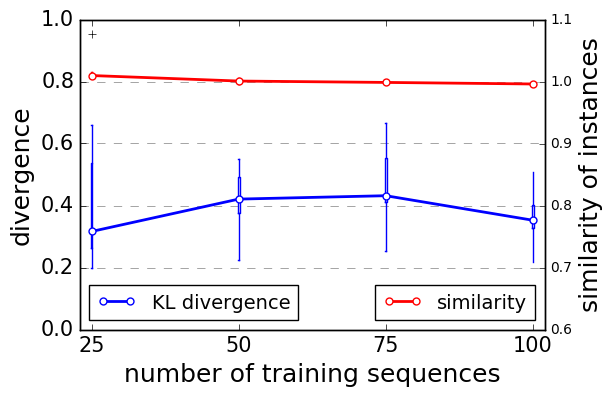

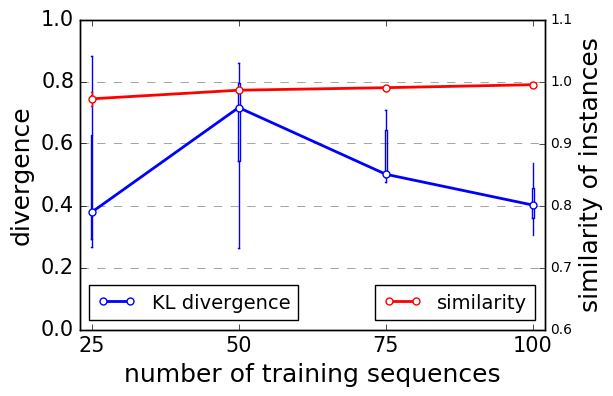

In [23]:

import oneclasscurve  as occ
sizes=[25,50,75,100]
#a,b = occ.get_results(repeats=2,sizes=sizes,njobs=4,argparam=1)

re= '''result = [[[0.37581779388964992, 0.72168206070861629, 0.36688498098995437, 0.58635464167451878, 0.52868202157837174, 0.42588967888706625, 0.63069316853441115], [0.58100875202534652, 0.30737263242588381, 0.64618155436767166, 0.63810747055001504, 0.31680206276217376, 0.46787767276715697, 0.56725633271362408], [0.3236698813874283, 0.41333311978935766, 0.53890150128962411, 0.41138805774059745, 0.39532070062971097, 0.43858653778234641, 0.51057238868654153], [0.7366091402233792, 0.45160063174280513, 0.52888148661776835, 0.45797015826526932, 0.4902035011780958, 0.28182270347308103, 0.39308711755403714]], [[1.0123666539562044, 0.988777307515185, 1.0057677198641259, 0.99749671148775254, 1.0041478130577048, 1.0104662378566382, 0.99901312903919193], [0.99594780388783677, 0.99582849488719194, 0.99593431605443494, 0.99537863937998428, 0.99336432100739869, 0.9955101402251767, 0.99354337095642176], [0.99703779825546412, 0.99188943312651645, 0.99507348751439373, 0.99125712556991175, 0.99625827670230127, 0.9951029222150104, 0.9956579199025235], [0.99607321035249841, 0.99410558339687849, 0.99529507707687792, 0.99482216678231927, 0.99453122330268762, 0.99502692102005841, 0.99450856631658946]]]
result = [[[0.18256729676510322, 0.71627851642233831, 0.60797092056967672, 0.77282817401370052, 0.55538118218315791, 0.23931018366694023, 0.37885263626368032], [0.3250043493527619, 0.82074933206918976, 0.47778675985258756, 0.20585708094961105, 0.13215492231967907, 0.43859022059622554, 0.37430651322857944], [0.53773560552580657, 0.45542866246784158, 0.65382853999947288, 0.39749751202384348, 0.36077924211506135, 0.25203820286993811, 0.58122788783658175], [0.36844853186673271, 0.61546509632095314, 0.64616534123475056, 0.44129074238248628, 0.66975861704664974, 0.54643966785988074, 0.52084902471188699]], [[0.97504580990472123, 0.97547759323134842, 0.99185081489860094, 0.98454388797048065, 0.98770969894779481, 0.98434633006786787, 0.98077629118179799], [0.98928824050828967, 0.99206993464294302, 0.99095093754759545, 0.98711298681802495, 0.98800004652821061, 0.9878746097098281, 0.99195839694663168], [0.99424956497998318, 0.99489218967887461, 0.99165748964699407, 0.99196987927108538, 0.99489456937152498, 0.99374953763576102, 0.9935237062295581], [0.99657217768780082, 0.99545616809521353, 0.99475036242790871, 0.99418724444515594, 0.99591086564855547, 0.99527771252465924, 0.9950725797733031]]]
result = [[[0.17533236082556028, 0.55217818673607377, 0.29807919626864959, 0.55938766020400699, 0.23836410129520022, 0.21562555226166139, 0.30771754974511195], [0.33161058741427502, 0.52979591217214816, 0.59922820966793233, 0.16173564117750958, 0.35863004835707796, 0.53843763940644196, 0.26658050129567373], [0.54125429297576122, 0.35374717325417082, 0.2096774424132328, 0.2933309932164534, 0.37338214859355628, 0.41772035779959826, 0.41250341710126309], [0.40089103641191187, 0.47005866722685835, 0.47669138532096683, 0.78644813990381246, 0.5918442173477404, 0.70905116366616616, 0.54411120067645868]], [[0.983179375665031, 0.97534716481900963, 0.99095216217970894, 0.99438523388379052, 0.98380018380899692, 0.99384257218961669, 0.9750913083607603], [0.98665119639945997, 0.98503634755464131, 0.98759102960922895, 0.98295719743447407, 0.99309052533115327, 0.98850076384256558, 0.98630746687948534], [0.9600240414363127, 0.95701946877258715, 0.97479742973692474, 0.97498159218873182, 0.95775093570576775, 0.96600857658118311, 0.9648885755749812], [0.97756183330472923, 0.96553105335356237, 0.97370487145781048, 0.97792474442068411, 0.97808059905028133, 0.96934698388759044, 0.97431687816973644]]]
result = [[[0.73799673068876803, 0.39202160707778461, 0.65325280927254237, 0.33036151321493906, 0.51259572523486308, 0.43939239915092293, 0.44085572063647677], [0.3091938389543834, 0.31243487107604379, 0.65527837950997436, 0.42945775135520492, 0.30120831467091774, 0.52472351791826999, 0.67970564203528783], [0.42086360761611497, 0.33611272754535432, 0.30338345433492159, 0.43987482475583373, 0.33084664618696324, 0.6944268598556812, 0.64631903758197751], [0.47262471286050012, 0.47584137658572656, 0.34472424857229883, 0.4122562614705847, 0.40894810616906824, 0.52847022337857541, 0.4938300539298453]], [[1.0099345920250833, 1.0127304136021329, 1.0136043680528191, 1.0148569944216352, 1.0068998949558534, 1.0104197048592551, 1.0104689752507507], [1.0022762266098857, 0.99911924538017427, 1.0027874593994177, 1.0014218019005749, 1.0032686983556052, 1.0018650162129776, 1.0029673995194697], [0.99899159884597466, 0.99673273438935694, 0.9972920800089814, 0.99574253723509221, 0.99754347007121469, 0.99626003085153969, 0.99383972449013513], [0.99320375167369956, 0.9952560187620284, 0.99678316803152633, 0.99505605531736629, 0.99774003470529793, 0.99653708879271652, 0.99468647592611681]]]
result = [[[0.37946672295895362, 0.25570532168065702, 0.40709577278309855, 0.44630672458884063, 0.51731026824214688, 0.28508964590533464, 0.34081153359857902], [0.50361725635414456, 0.31140022003742834, 0.73730546136970831, 0.5752227664755365, 0.47689277852115824, 0.31081038641150077, 0.39841622540545441], [0.51578339320695155, 0.53155477286596264, 0.28181074294045932, 0.31455562400374665, 0.54616222839807305, 0.47131150993497356, 0.32687747141852469], [0.46477823197571322, 0.79695575492046811, 0.7219546101863048, 0.55032220346278482, 0.84030291265461254, 0.42434835227143658, 0.3849508690034058]], [[1.0226832878286725, 1.0120061138752066, 1.0152028049785646, 1.0039843799844947, 1.014387759149626, 1.0186188608800328, 0.99852930774201343], [0.99857835151312402, 1.0024859029711437, 1.0085303831251042, 1.0058636760189292, 1.0019157947968429, 0.99702553779632275, 1.0036177533067132], [0.98641661124707603, 0.98944333459674239, 0.98620396504985264, 0.99465821524500186, 0.98734613882526789, 0.98890558889894142, 0.98580741460685528], [0.97760690909295744, 0.98150897512640478, 0.98359608573153345, 0.97617779658077952, 0.97817899998694635, 0.98548969902987626, 0.97879987395456769]]]
result = [[[0.25332960785406466, 0.5430415194598367, 0.36724520287966717, 0.6578962941884946, 0.18128069757214901, 0.23398867968407114, 1.0348912017348579], [1.1007470545920048, 0.30856169147479118, 0.20125017430684808, 0.39861397483692707, 0.27002623713024693, 0.42172440258329819, 0.2172835025231078], [0.55035772640541725, 0.3499785075180048, 0.4237243862200466, 0.32342331153247567, 0.52141697467158166, 0.48834886207398503, 0.34645968762389939], [0.42935982267733336, 0.47925116815485308, 0.42327551997277357, 0.29056622995733622, 0.27621408936530883, 0.36165928954274973, 0.22782351876341767]], [[1.0127793467143313, 1.0175312264619341, 1.0154972772374733, 1.0214358436791844, 1.0205979956316695, 1.0035842821049166, 1.019145941792891], [1.008640404379846, 1.0063211828585064, 1.0071041588138359, 1.0045985241323334, 1.0064150716154203, 1.00945837980786, 1.0067150177281223], [1.0050704427407644, 1.0031823351381743, 1.0032065177019736, 1.0032435626293028, 1.0032023879696923, 1.0014790076816062, 1.0039849656832085], [1.0008426656804967, 1.0019410169911305, 1.0007078936647078, 1.0009583043358441, 1.001641713529003, 1.0008170661155904, 1.0015029574934347]]]
result = [[[0.44512372989682625, 0.5707202395072315, 0.56004628419330238, 0.24428194463393493, 0.32756366402746762, 0.24794938949574638, 0.22815519349577515], [0.27789580871723413, 0.29462167747489787, 0.19302550629929374, 0.15507780804779148, 0.24603880484547849, 0.21981206121869237, 0.29622650225775515], [0.56667028673794029, 0.48761203538820541, 0.47267756275085199, 0.69241815063348078, 0.61041762802801314, 0.77598064489005969, 0.25258475544578585], [0.56347593857378586, 0.52479562685795489, 0.63914082100278369, 0.49798636022378667, 0.48655032239891133, 0.38464747982950825, 0.38163850524331616]], [[1.0164875735708512, 1.0297981365876472, 1.0109744597443899, 1.0236003241573455, 1.0093901394585849, 1.0238909570745642, 1.0245544970574558], [1.0021669064177474, 0.99844067963223748, 1.0001098849024901, 0.99090933636963063, 1.0045041619830579, 1.0015989909335732, 0.9926877719979319], [0.99482826719112349, 0.99159378801049147, 0.9933654355239776, 0.99416846002910997, 0.99503964364070308, 0.99368472103231409, 0.99338301223497671], [0.99074944499661799, 0.99304857466580576, 0.99198922093451847, 0.99273710506526813, 0.99501523882095433, 0.99019572997483651, 0.99153650815582794]]]
result = [[[0.32445270531744463, 0.56103641580189878, 0.24530179019665821, 0.44363850724603804, 1.3496905497185854, 0.57740800620215971, 0.19856803725651859], [0.36812878329999071, 0.42671265842538592, 0.34000130610934437, 0.43560727695582058, 0.248754967177096, 0.33064287608467574, 0.62370954784235633], [0.48053919589707145, 0.49195333634668298, 0.44620051450327763, 0.87497936519617081, 0.95029741966865522, 0.52693003689644946, 0.42255522411829632], [0.37981795255255646, 0.40095379785905766, 0.2658882642972466, 0.30701586501929018, 0.37253849171211045, 0.38986176130090894, 0.44560142861429264]], [[0.99868908811471258, 1.0073994680640372, 1.0140864383166837, 1.0111547682231119, 1.0139506158337688, 1.0093952554261496, 1.010270831976835], [1.004454706536374, 1.0030473613853506, 1.003344213434447, 1.00028045975379, 0.99923212486115964, 1.0027387505593213, 1.0008640467615633], [0.99972927511713738, 1.0004701949449075, 1.0003910869591885, 0.99990668928929893, 0.99645259418654741, 0.99998894457490572, 0.99953359687602072], [0.99621755128559375, 0.99584207258574575, 0.99745279078343441, 0.9953780674441628, 0.99683650110041533, 0.99782355296119896, 0.99726262078545125]]]
result = [[[0.54548394560933011, 0.46684448147904689, 0.34050708857613093, 0.38177736800505557, 0.43366446810444143, 0.34729327874668564, 0.3688860251698684], [0.52447837592412183, 0.72714275083595181, 0.91448557791059037, 0.95998173546992172, 0.99956747049849304, 0.66491052487355706, 0.9198162549900526], [1.1857023900999675, 0.8987098482532242, 1.1946901536113366, 1.2175708083106083, 1.1413032292507588, 1.5278208040717136, 1.085568863508215], [1.1226518735090296, 0.72438297890661085, 0.74774075362532377, 0.89890375992533122, 0.52660964145548583, 0.68469567728313863, 1.128359625888071]], [[1.0141406673284603, 1.0146511001298653, 1.012854201239648, 1.0139813052270739, 1.0085995660891329, 1.0039244436199131, 1.0096246097761754], [0.96101363261793893, 0.95501081792197928, 0.96473281356929175, 0.95048888399451859, 0.95138108526829257, 0.96073639010369905, 0.96010333662026071], [0.95563398335423366, 0.94405036652331076, 0.94639181615275958, 0.96934765575836535, 0.95183357150104508, 0.96365611234335558, 0.95093160793656839], [0.96579189687797817, 0.97573218925595628, 0.96958925256423689, 0.96692402206719308, 0.97420848215192091, 0.96971523355794098, 0.96767597376408632]]]
result = [[[0.62145798641661143, 0.42536915857080082, 0.9704992209378025, 0.52800714894722267, 0.28158471482150932, 0.24813488550693519, 0.70063025258873024], [0.55948081013047313, 0.84621239898393241, 0.91753068141788197, 0.67708415996651283, 0.71604527223343473, 1.0617980980646677, 0.77277611521603884], [0.44042450245087439, 0.59084962381783412, 0.59607648219038245, 0.98004029501117407, 0.62290536203692948, 0.74736756062420528, 0.71692701682572857], [0.62793672736748152, 0.86583377733906841, 1.6327894155194069, 0.45833793222030966, 0.65091447866633811, 0.69855150650997488, 0.463988027952772]], [[1.0173362455958681, 1.0283078823445064, 1.0167469337564066, 1.0102851869312484, 1.0236760831900937, 1.0093060072063029, 1.0302634297841176], [0.93227363257761164, 0.93300942160170675, 0.92668071557859433, 0.93830681254754755, 0.92407105640789156, 0.91116094225327549, 0.9241874226672907], [0.93930967202151106, 0.92772062448719728, 0.93309737787886193, 0.91659145557119059, 0.93242917555497462, 0.9190030237861645, 0.91809868944332595], [0.94803774489680648, 0.93241254561816511, 0.93761305846839427, 0.93523109116258296, 0.93775077688199338, 0.93266644703586732, 0.93990995207570405]]]
result = [[[0.68009350309572625, 0.22372117525145599, 0.43449233281119953, 0.24497457955910554, 0.2689023301815775, 0.49260110394612483, 0.56276321358320536], [0.7440761796270593, 1.0159899492190805, 0.90625199656582611, 0.7326469658397694, 0.54210844379550138, 0.89553353117682111, 0.83021763110122249], [0.65876942989570852, 0.74675840455089715, 0.84945410508500585, 0.5057364892247822, 1.1914461855212475, 0.46090396667377348, 0.56461727280954366], [0.59450065008057562, 0.87209487910360195, 0.69699907012864537, 0.68808657882754221, 0.56483463482312157, 0.6141226003545458, 0.8708806356967701]], [[0.98993596521886795, 1.0240156217487724, 1.0021230744654857, 1.0307980011086975, 1.0086770550580673, 1.0257054584019805, 1.0324174135552739], [0.93158890883295975, 0.9495922238859259, 0.93112478026830914, 0.94678301931024789, 0.95504633363589631, 0.95956536916793578, 0.94178979565647836], [0.9369606414353997, 0.94530932971466264, 0.93072161629288397, 0.9448276662932904, 0.94740928583507011, 0.94141744776870873, 0.94027365878556424], [0.95896017990420801, 0.97494739605399316, 0.95238313778273131, 0.96552771825126726, 0.96012992319627843, 0.97006717047209379, 0.9520126796938494]]]
result = [[[0.27754260385175283, 0.1943753657475937, 0.29122508366935312, 0.86221518876940362, 0.36465631722191955, 0.43540357241368127, 0.30732765887608254], [0.58444904628081806, 1.0532954251006748, 0.671165232621727, 0.77481581611669503, 0.76742605498937821, 0.57103161490233323, 0.41030074220022206], [0.70190604283428115, 0.54558111448839508, 0.98670376306686736, 0.67954158821071609, 0.60162878042583989, 0.87245874908536958, 0.92643748961100858], [0.37558847726364708, 0.55978832637328091, 0.53504339312544558, 0.43056366696847365, 0.40640244689593857, 0.44940585129737015, 0.46129861066923822]], [[1.0164116420681546, 1.0049135946618306, 1.021678756632888, 1.0211538156243223, 1.0217501257564281, 1.0139564111407147, 1.0208286181364348], [0.98423657154711508, 0.97001718580687435, 0.95990863400539472, 0.96406620875804527, 0.96346680611950164, 0.96120588315488376, 0.96651136346376476], [0.96704085845052823, 0.96311096832581666, 0.95758014004002712, 0.96365400050021732, 0.96806964653611194, 0.95812385583736703, 0.96821958965209276], [0.98145976550583436, 0.98309261169155249, 0.97920777861173203, 0.98449057165979947, 0.97661313074547862, 0.98300358623552531, 0.97833898494440397]]]
result = [[[0.80823337736354528, 0.51598160296214679, 0.29004545275334503, 0.49300949034498903, 0.56670828535554307, 0.54503141764446572, 0.26391104824070305], [0.91885495341188994, 0.50239094508701099, 0.85778188443153791, 0.95487858896667444, 0.83071756500323179, 0.76120774499270671, 0.67570862615341587], [0.95670251885388724, 1.0920915853033859, 0.74559911194021911, 1.3835166069115743, 1.0560264849187742, 1.0380868881715009, 1.0387780038701357], [0.94832800290952146, 0.47496423179104691, 0.57221719682454497, 0.75533448992569996, 0.75834166633847044, 0.75708538073979703, 0.5182306808738063]], [[1.0032984947071073, 0.99871402858777047, 1.0061831676340123, 1.0080709661341078, 1.0005918981482782, 0.99770103922756892, 0.9981456825776539], [0.96280081309139265, 0.96031680635793382, 0.96416999304566031, 0.96245807891125401, 0.95305373427029516, 0.95445743998173638, 0.95560749066963302], [0.96562891022523156, 0.96830040826998309, 0.96867460425228546, 0.96128860256943016, 0.96393574400774473, 0.9570158074630275, 0.96650040476509014], [0.97790094670123362, 0.9848007855212898, 0.98186124953941345, 0.984292732908158, 0.98188018098359131, 0.97574215805166431, 0.98420722041168363]]]
result = [[[0.57994803339806866, 0.20627312001446022, 0.2614135005656365, 0.22087333405243381, 0.59993186830335243, 0.23113340814774952, 0.54350700582287603], [0.98748946351661215, 0.51055746992166462, 1.148512978105982, 0.80035688936279437, 1.0272202020085577, 0.67875921790294935, 1.5246259362902304], [0.85553835513140319, 0.92993533777157023, 0.8194682405069198, 0.70371890644976187, 0.83719233196138454, 1.2350523274613925, 0.83824229339709533], [1.1461282357324414, 1.1220888360343451, 1.3274944201197236, 0.7511919294717323, 0.92677388186284571, 1.0078170303699363, 0.87185139314580684]], [[0.9739413602475816, 1.0176492386755072, 1.0156840668009239, 1.0135330108134373, 1.0138059801256305, 1.0082435172457525, 1.0152544050816745], [0.92135625165659574, 0.91178548920271985, 0.91583848893087094, 0.90916652633105621, 0.91539025845534572, 0.92486848617582385, 0.91184775200872625], [0.92668869798077746, 0.93496186231895817, 0.94280976162657792, 0.96670643263161538, 0.93243281905077857, 0.94941214928662121, 0.93463773245144921], [0.95870350093465684, 0.95891379530116716, 0.97150847640017435, 0.97722723595584449, 0.95677412714279997, 0.95349006716175488, 0.9614571012912162]]]
result = [[[0.2750041287417056, 0.59447795662485048, 0.48092049594403341, 0.40579274547999461, 1.197921486032721, 0.20877549184340163, 0.52674204632450661], [0.74299364395020129, 0.42255556393446209, 1.1337029850104952, 1.3265565302511855, 0.44018234252350763, 1.0397803552834, 0.80870549189960361], [0.85807226362841804, 1.1021778472250581, 0.93065772735554619, 0.99640947141854408, 0.89539348080736192, 0.88714526373430225, 0.74536750855510492], [1.4107194213128045, 1.12721618208026, 1.1143948343329488, 1.3079173077422208, 1.1623194779060027, 1.2196788005083328, 0.90209699625407891]], [[0.97233823634512206, 1.0300445253103441, 1.0110995786893557, 1.0097077626028204, 1.0335727104040542, 1.0165682574867236, 1.0240555401031517], [0.88401507277167568, 0.88754737814945217, 0.83168649840232611, 0.86820421069414966, 0.86950504489760505, 0.84510887283762159, 0.81841242894464572], [0.88651813689504089, 0.93193031107728996, 0.93219351848615539, 0.93597661574154722, 0.90495391381295731, 0.8975209535614479, 0.93016572926629282], [0.93640915752751119, 0.92400380035918672, 0.92801547026103848, 0.94171789500048109, 0.93394682295556031, 0.95236975838181559, 0.93992665716747581]]]
result = [[[0.14450986939460311, 0.3803042481504772, 0.43008219902508832, 0.37598974739725538, 0.5392830933902738, 0.18427156404077297, 0.47705352510136545], [0.47004583294241314, 0.4584100884791093, 0.50552788351650069, 0.46268638245711097, 0.42593618554008145, 0.23886345035157652, 0.50737279572979099], [0.42983357535575722, 0.52852588726065619, 0.40835831197829159, 0.33906500108496723, 0.56207164193089854, 0.51666990939737301, 0.26563460515294207], [0.57665793012944599, 0.36268414009558381, 0.38502311534807304, 0.52871228449341923, 0.53365319158255264, 0.51127281679100867, 0.57440452712143431]], [[1.0304589046563297, 1.0230768982483076, 1.0280801149125278, 1.0346911600233468, 1.0293721827471212, 1.0354884006774847, 1.0236523663523089], [0.96676925614659071, 0.98311012282154842, 0.97617520489122533, 0.95658377748674872, 0.97517620776849057, 0.9729842158700327, 0.97140221084340228], [0.98382848613751162, 0.96606026291328106, 0.9833238851946372, 0.98062874983341519, 0.96958501361890537, 0.97155958315879543, 0.97180666661793225], [0.97731900845125308, 0.99238298894525778, 0.98619660747412941, 0.98051203276187493, 0.98716754468400469, 0.98458358300479543, 0.97795629821101016]]]
result = [[[0.52939402497567223, 0.36770306523157198, 0.21510450539965217, 0.084760776004408414, 0.33354886142208429, 0.32961949092167447, 0.2125145404330375], [0.78106855563665245, 0.64098457607083714, 0.45149995492727485, 0.53027423314574762, 0.54470603089659508, 0.62774364515505132, 0.54419594966216933], [0.41787710840595543, 0.58508923069831464, 0.90011387366062079, 0.68871506953205497, 0.57360955983274742, 0.48098661677689464, 0.57847409237848613], [0.4563689176385517, 0.66955165190575128, 0.5363002712012811, 0.55122849358132342, 0.56652170015614034, 0.62335272919606155, 0.61088767404768551]], [[0.96333519871003959, 1.0127385096927726, 1.0248545211858808, 1.034250235503434, 1.016631216372698, 1.0177528759524159, 1.0255029514089138], [0.97148813735132689, 0.980680535405827, 0.98620806045719234, 0.982220662634263, 0.98271618767766111, 0.97696472641984144, 0.9845613578467689], [0.9681150962362628, 0.96554719627388086, 0.9648177536271576, 0.97238788052986036, 0.97226893696466044, 0.96848452057358325, 0.97588203331071421], [0.98096917938584582, 0.9822822936011355, 0.98252143621878119, 0.97786665817321261, 0.98116494109488617, 0.97769801319877314, 0.98346891196352038]]]
result = [[[0.28862992254353043, 0.42019937646887257, 0.39451241589406388, 0.30041661474056042, 0.36266224731223379, 0.48813307712089177, 0.50793610636990871], [0.4114037099705814, 0.45046531489200409, 0.32802795012441893, 0.260350016127888, 0.30242773235019815, 0.34850445106008837, 0.29865031281796495], [0.51215009269156564, 0.55476650605499189, 0.52876813561113423, 0.26289626751076406, 0.55429586307532064, 0.59623362594208473, 0.75469840995458959], [0.3978786577486339, 0.63241068668323441, 0.6319734829030722, 0.42927178110955327, 0.47565143128310888, 0.45627029651824857, 0.44610333607362634]], [[0.90083822116807133, 1.0019386263754233, 0.99716547190709948, 0.98908333335083265, 0.99695954780098994, 0.99308157485427795, 1.0039075047391297], [0.98788585308658672, 0.99166104219329287, 0.99328950823579443, 0.99181516561457228, 0.99297788037111123, 0.99123840626124704, 0.99072533024287779], [0.99416657014085774, 0.99434305618556595, 0.99391501521178693, 0.99052375105515833, 0.99105532433726462, 0.98778514720491972, 0.98861329449089386], [0.99189512097115762, 0.98923209444814197, 0.99192124382312108, 0.99255783449161616, 0.99304701518378002, 0.99056854072290612, 0.99058270530797898]]]
result = [[[0.31614218348998302, 0.28961730898471844, 0.19962121259185386, 0.65990362902727429, 0.41364244505362774, 0.23800542306242023, 0.95473842327946434], [0.47136749032764252, 0.54984351026504052, 0.34008823156301932, 0.22282041973499597, 0.42065820707331286, 0.51522861069862314, 0.41346330130767711], [0.54576406122527377, 0.66685221350134516, 0.43159445496554355, 0.25436756364263291, 0.56164441283294508, 0.40441208330053541, 0.41605108558297249], [0.44091521316244003, 0.36485784071069616, 0.35207478680931054, 0.21711170207483044, 0.30353537936481095, 0.50889533255334596, 0.35236625732963284]], [[1.0090110360917661, 1.0089349355334019, 1.0100553299350166, 1.0096354626098771, 1.0138162740079479, 1.0150913568120592, 1.0052539666639693], [0.99771691033252807, 0.99600531009332516, 1.0039690971154989, 1.0025644274639187, 1.0057789614575476, 0.99909158829337152, 1.0007310181014606], [0.99857554923721281, 0.99796121350424771, 0.99625637862473437, 0.99906811367921389, 0.9958874586630998, 0.99872127390806287, 0.99850770967995073], [0.9959953021133201, 0.99561756268962842, 0.99340373371416146, 0.99511248666902286, 0.99727659727929896, 0.99711001377752539, 0.99801838485077865]]]
result = [[[0.37799476857464187, 0.54617825293749689, 0.27904495772945098, 0.26726236373200735, 0.7082906777723178, 0.88213010308630257, 0.30718978262183866], [0.71592692669059554, 0.45831299551679167, 0.62742015798579531, 0.86002217013241988, 0.26140983066258033, 1.2127382746093192, 0.7320360542511205], [0.49551921864299003, 0.47734822972852786, 0.67660650677255985, 0.48828968805553546, 0.7092441404697386, 0.50073173552853234, 0.6123034760720153], [0.45016715764666043, 0.30331671045058001, 0.40127660584526365, 0.3416881146740347, 0.53615314676926862, 0.37887860416347841, 0.46004368267982215]], [[0.98295827417909365, 0.97154166543215337, 0.97236304957694397, 0.97203934413364934, 0.98299547013786148, 0.96072107422558317, 0.96651766101384773], [0.98952169525875544, 0.98905964300189153, 0.98203250029083267, 0.98595880837129612, 0.98944016582153804, 0.98304493418383632, 0.9848283499472017], [0.99002114078156878, 0.98870216096830477, 0.99004208636574897, 0.99162461252946699, 0.9908342160839203, 0.9839681324192131, 0.9869723984266513], [0.99484527254050859, 0.99639316402315259, 0.99662636719935771, 0.99760673107527276, 0.99471462464849558, 0.99482957900409275, 0.99374490041417418]]]'''
re= '''result = [[[0.37581779388964992, 0.72168206070861629, 0.36688498098995437, 0.58635464167451878, 0.52868202157837174, 0.42588967888706625, 0.63069316853441115], [0.58100875202534652, 0.30737263242588381, 0.64618155436767166, 0.63810747055001504, 0.31680206276217376, 0.46787767276715697, 0.56725633271362408], [0.3236698813874283, 0.41333311978935766, 0.53890150128962411, 0.41138805774059745, 0.39532070062971097, 0.43858653778234641, 0.51057238868654153], [0.7366091402233792, 0.45160063174280513, 0.52888148661776835, 0.45797015826526932, 0.4902035011780958, 0.28182270347308103, 0.39308711755403714]], [[1.0123666539562044, 0.988777307515185, 1.0057677198641259, 0.99749671148775254, 1.0041478130577048, 1.0104662378566382, 0.99901312903919193], [0.99594780388783677, 0.99582849488719194, 0.99593431605443494, 0.99537863937998428, 0.99336432100739869, 0.9955101402251767, 0.99354337095642176], [0.99703779825546412, 0.99188943312651645, 0.99507348751439373, 0.99125712556991175, 0.99625827670230127, 0.9951029222150104, 0.9956579199025235], [0.99607321035249841, 0.99410558339687849, 0.99529507707687792, 0.99482216678231927, 0.99453122330268762, 0.99502692102005841, 0.99450856631658946]]]
result = [[[0.18256729676510322, 0.71627851642233831, 0.60797092056967672, 0.77282817401370052, 0.55538118218315791, 0.23931018366694023, 0.37885263626368032], [0.3250043493527619, 0.82074933206918976, 0.47778675985258756, 0.20585708094961105, 0.13215492231967907, 0.43859022059622554, 0.37430651322857944], [0.53773560552580657, 0.45542866246784158, 0.65382853999947288, 0.39749751202384348, 0.36077924211506135, 0.25203820286993811, 0.58122788783658175], [0.36844853186673271, 0.61546509632095314, 0.64616534123475056, 0.44129074238248628, 0.66975861704664974, 0.54643966785988074, 0.52084902471188699]], [[0.97504580990472123, 0.97547759323134842, 0.99185081489860094, 0.98454388797048065, 0.98770969894779481, 0.98434633006786787, 0.98077629118179799], [0.98928824050828967, 0.99206993464294302, 0.99095093754759545, 0.98711298681802495, 0.98800004652821061, 0.9878746097098281, 0.99195839694663168], [0.99424956497998318, 0.99489218967887461, 0.99165748964699407, 0.99196987927108538, 0.99489456937152498, 0.99374953763576102, 0.9935237062295581], [0.99657217768780082, 0.99545616809521353, 0.99475036242790871, 0.99418724444515594, 0.99591086564855547, 0.99527771252465924, 0.9950725797733031]]]
result = [[[0.31614218348998302, 0.28961730898471844, 0.19962121259185386, 0.65990362902727429, 0.41364244505362774, 0.23800542306242023, 0.95473842327946434], [0.47136749032764252, 0.54984351026504052, 0.34008823156301932, 0.22282041973499597, 0.42065820707331286, 0.51522861069862314, 0.41346330130767711], [0.54576406122527377, 0.66685221350134516, 0.43159445496554355, 0.25436756364263291, 0.56164441283294508, 0.40441208330053541, 0.41605108558297249], [0.44091521316244003, 0.36485784071069616, 0.35207478680931054, 0.21711170207483044, 0.30353537936481095, 0.50889533255334596, 0.35236625732963284]], [[1.0090110360917661, 1.0089349355334019, 1.0100553299350166, 1.0096354626098771, 1.0138162740079479, 1.0150913568120592, 1.0052539666639693], [0.99771691033252807, 0.99600531009332516, 1.0039690971154989, 1.0025644274639187, 1.0057789614575476, 0.99909158829337152, 1.0007310181014606], [0.99857554923721281, 0.99796121350424771, 0.99625637862473437, 0.99906811367921389, 0.9958874586630998, 0.99872127390806287, 0.99850770967995073], [0.9959953021133201, 0.99561756268962842, 0.99340373371416146, 0.99511248666902286, 0.99727659727929896, 0.99711001377752539, 0.99801838485077865]]]
result = [[[0.37799476857464187, 0.54617825293749689, 0.27904495772945098, 0.26726236373200735, 0.7082906777723178, 0.88213010308630257, 0.30718978262183866], [0.71592692669059554, 0.45831299551679167, 0.62742015798579531, 0.86002217013241988, 0.26140983066258033, 1.2127382746093192, 0.7320360542511205], [0.49551921864299003, 0.47734822972852786, 0.67660650677255985, 0.48828968805553546, 0.7092441404697386, 0.50073173552853234, 0.6123034760720153], [0.45016715764666043, 0.30331671045058001, 0.40127660584526365, 0.3416881146740347, 0.53615314676926862, 0.37887860416347841, 0.46004368267982215]], [[0.98295827417909365, 0.97154166543215337, 0.97236304957694397, 0.97203934413364934, 0.98299547013786148, 0.96072107422558317, 0.96651766101384773], [0.98952169525875544, 0.98905964300189153, 0.98203250029083267, 0.98595880837129612, 0.98944016582153804, 0.98304493418383632, 0.9848283499472017], [0.99002114078156878, 0.98870216096830477, 0.99004208636574897, 0.99162461252946699, 0.9908342160839203, 0.9839681324192131, 0.9869723984266513], [0.99484527254050859, 0.99639316402315259, 0.99662636719935771, 0.99760673107527276, 0.99471462464849558, 0.99482957900409275, 0.99374490041417418]]]'''

for line in re.split("\n"):
    lin = line[8:]
    a,b= eval(lin)
    occ.plot('123',sizes,a,b)


[ 25  50  75 100]


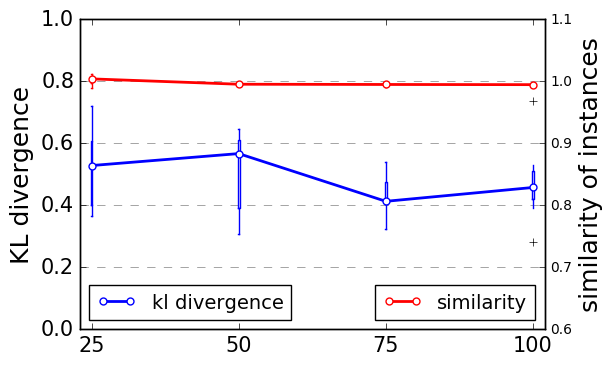

In [19]:

import oneclasscurve  as occ
occ.plot('123',sizes,a,b)

In [5]:
 a=eval('[1,2]')
print a

[1, 2]


In [ ]:
import numpy as np
a=np.array([[ 0.09634476 , 0.90365524],
 [ 0.06088005,  0.93911995],
 [ 0.07065094 , 0.92934906],
 [ 0.04671271,  0.95328729],
 [ 0.02970209 , 0.97029791],
 [ 0.29515478 , 0.70484522],
 [ 0.86338974 , 0.13661026],
 [ 0.80168559 , 0.19831441],
 [ 0.80968646 , 0.19031354],
 [ 0.12463197  ,0.87536803],
 [ 0.1517372   ,0.8482628 ],
 [ 0.34249768,  0.65750232],
 [ 0.07255634,  0.92744366],
 [ 0.02922214,  0.97077786],
 [ 0.77822639,  0.22177361],
 [ 0.81886221,  0.18113779],
 [ 0.16694517,  0.83305483],
 [ 0.12744298,  0.87255702],
 [ 0.09078483,  0.90921517],
 [ 0.04598973,  0.95401027],
 [ 0.80762083 , 0.19237917],
 [ 0.03582149 , 0.96417851],
 [ 0.82493818  ,0.17506182],
 [ 0.07749642 , 0.92250358],
 [ 0.52502072 , 0.47497928],
 [ 0.20059041 , 0.79940959],
 [ 0.54677554  ,0.45322446],
 [ 0.75185612  ,0.24814388],
 [ 0.72276445 , 0.27723555],
 [ 0.78464842 , 0.21535158],
 [ 0.41365199 , 0.58634801],
 [ 0.09839525 , 0.90160475],
 [ 0.03955736  ,0.96044264],
 [ 0.39204652  ,0.60795348],
 [ 0.58669915  ,0.41330085],
 [ 0.09951188  ,0.90048812],
 [ 0.69697943  ,0.30302057],
 [ 0.7775214   ,0.2224786 ]])

print a[:,0]
